## Intro 
In this notebook we will apply knowledge gathered from previous analysis to kegg ortologs, this dataset is focused on even lower level biounits than bacteria famillies and pathways, and thus we have much more features, this means we can utilise 1D CNN networks in order to try to reduce number of parameters in the model, We have to remember that CNN try to find structural patterns and we dont necccesarily have ones in our dataset as positioning of columns is random. Nevertheless we decided to test this approach   

### Import libraries and load data

In [2]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# for tensorboard logs
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, SMOTEN
from keras.layers import Dense, Dropout, Activation, Flatten
np.random.seed(111)
tf.random.set_seed(111)


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Data/sed_KEGG_ortholog_merged.csv')


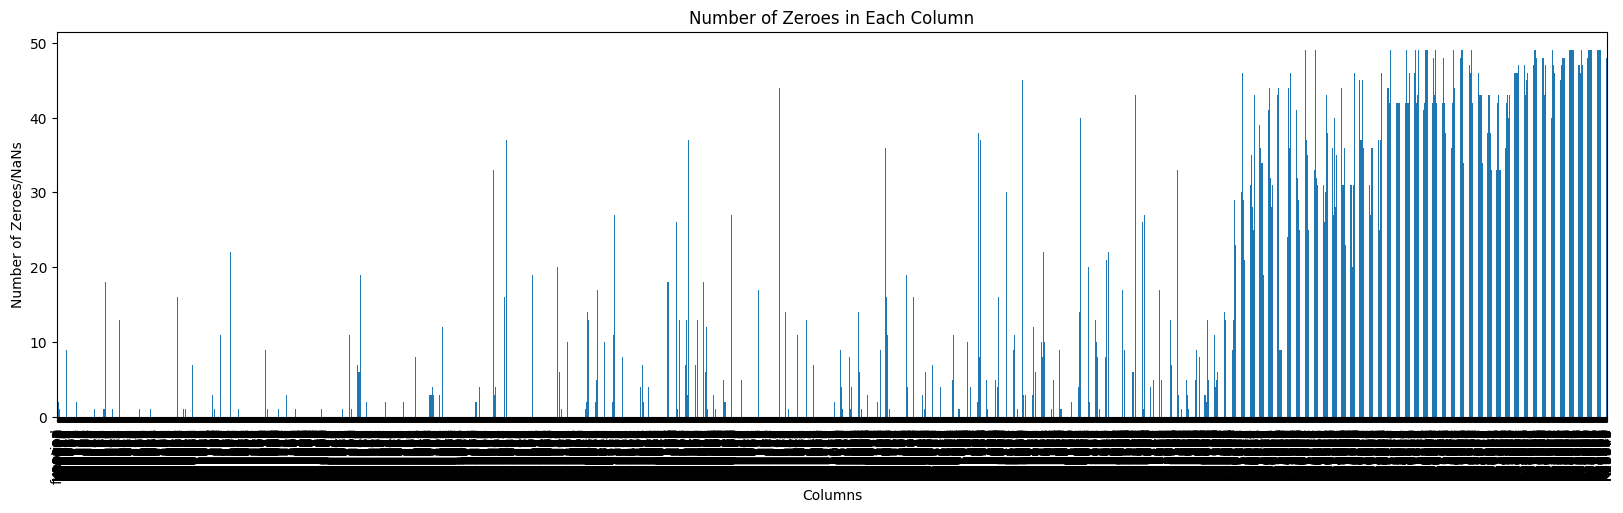

In [4]:
zero_counts = ((df == 0) | (df.isna())).sum()
zero_counts.plot(kind='bar', figsize=(20, 5))
plt.xlabel('Columns')
plt.ylabel('Number of Zeroes/NaNs')
plt.title('Number of Zeroes in Each Column')
plt.show()

Judnging from this plot we dont have that much missing observations this means that in sediment dataset which we have here most of the organisms lived in most of the ponds, we also have a big set of organisms that lived onyly in one kind of setup, This should give model enough information to classify.

In [5]:
print(df.shape)
df.head()

(50, 6370)


,pond,function,K00001,K00002,K00003,K00004,K00005,K00006,K00007,K00008,...,K19734,K19744,K03955,K06157,K07450,K07682,K12567,K15643,K16875,K18376
0,S29,S29.209.Sed,1111.21,26.0,2778.48,125.0,170.0,10.0,12.0,897.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S29,S29.210.Sed,393.50,17.0,1221.01,31.0,145.0,0.0,0.0,448.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S27,S27.239.Sed,782.34,40.0,1608.34,56.5,135.0,65.0,13.0,771.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S27,S27.240.Sed,763.34,31.5,2032.50,80.5,187.5,0.0,8.0,717.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S28,S28.225.Sed,1039.50,34.5,2696.00,79.0,238.5,38.0,37.0,1065.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
ID = df['function'].str.split('.').apply(lambda x: x[1] if len(x) > 1 else None)
df.insert(1, 'ID', ID)

In [7]:
df.sort_values('ID', inplace=True)

In [8]:
predictors = df.columns[3:]
print(f"number of predictors/bacteria famillies: {len(predictors)}")
      
# adding collumn with timepoints 
classes = np.tile([0, 1], 25)
df.insert(1,"timepoint",  classes)

# replacing NaN values with 0
df.fillna(0, inplace=True)

df.head()



number of predictors/bacteria famillies: 6368


,pond,timepoint,ID,function,K00001,K00002,K00003,K00004,K00005,K00006,...,K19734,K19744,K03955,K06157,K07450,K07682,K12567,K15643,K16875,K18376
18,S08,0,201,S8.201.Sed,1159.84,19.50,2516.72,104.0,104.00,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
19,S08,1,202,S8.202.Sed,1941.66,196.50,3301.84,162.0,633.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
46,S14,0,203,S14.203.Sed,750.50,0.00,2195.99,86.5,22.33,99.0,...,0.0,0.0,0.0,0.0,11.0,11.0,0.0,0.0,1.33,0.0
47,S14,1,204,S14.204.Sed,1283.44,36.00,3120.13,153.0,330.58,20.0,...,0.0,0.0,0.0,15.0,0.0,0.0,12.0,12.0,8.33,12.0
15,S18,0,205,S18.205.Sed,1111.16,12.26,3069.75,134.5,10.52,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [9]:
df.drop(columns=['function'], inplace=True)

In [10]:
# for normalisation we will use starndard min-max normalisation
scaler = MinMaxScaler()
df[predictors] = scaler.fit_transform(df[predictors])




| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [11]:
df['pond_org'] = df['pond']

C:\Users\marek\AppData\Local\Temp\ipykernel_26216\3039816547.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['pond_org'] = df['pond']


In [12]:
# Decoding use pond decoder 2 for this

codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}


    

df['pond']=df['pond_org'].apply(lambda x: pond_decoder(x, codes))


In [13]:
# defragmenting 
df = df.copy()

In [29]:
df['pondXtime'] = df['pond'].astype(str) + df['timepoint'].astype(str)

In [30]:
train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['pondXtime'])
print(train_val_df.shape, test_df.shape)

(40, 6373) (10, 6373)


### Definitions

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [16]:
# early stopping callback to save the best model weights for test set
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=100,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

### Modeling timepoints
First thing that we are going to try is the only thing that worked properly wchich is modeling timepoints only.

In [24]:
model0 = keras.Sequential()
model0.add(keras.layers.Dense(1024,input_shape=(len(predictors),),activation='relu'))
model0.add(keras.layers.Dense(254, activation ='relu'))
model0.add(keras.layers.Dropout(rate=0.25))
model0.add(keras.layers.Dense(128, activation ='relu'))

model0.add(keras.layers.Dense(64, activation ='relu'))
model0.add(keras.layers.Dense(16, activation ='relu'))
model0.add(keras.layers.Dropout(rate=0.25))
model0.add(keras.layers.Dense(16, activation ='relu'))

model0.add(keras.layers.Dense(2, activation ='softmax'))

print(model0.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model0.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 1024)           │     6,521,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,824,448 (26.03 MB)

 Trainable params: 6,824,448 (26.03 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 2
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0037
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
predicted classes:       [0 0 1 1 0 1 1 0 1 0]
true validation classes: [0 0 1 1 0 1 1 0 1 0]
mean confidence score: 3.77474905725914e+26, sd confidence score: 1.1250013001197722e+27
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9000 - loss: 0.2012
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [1 0 1 1 1 1 0 0 1 1]
true validation classes: [1 0 1 1 1 1 0 0 1 0]
mean confidence score: 284647536377127.0, sd confidence score: 853942603989234.6
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 3.5087e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [1 0 0 1 1 0 1 0 1 1]
true validation classes: [1 0 0 1 1 0 1 0 1 1]
mean confidence score: inf, sd confidence score: nan
training for 4 subset


c:\Users\marek\My Drive\Ryby\Ryby\sed_based\functions.py:115: RuntimeWarning: divide by zero encountered in scalar divide
  confidence_score = round(((highest / mean)-1),4)
C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9000 - loss: 1.7400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted classes:       [1 1 1 0 0 1 0 0 1 0]
true validation classes: [1 1 0 0 0 1 0 0 1 0]
mean confidence score: 9.30803927530104e+25, sd confidence score: 2.7924116584247287e+26
training for 5 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 3.2186e-07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicted classes:       [0 0 1 0 0 0 1 0 1 1]
true validation classes: [0 0 1 0 0 0 1 0 1 1]
mean confidence score: 2.3157443849191875e+33, sd confidence score: 6.947233085310062e+33
validation set mean accuracy: 0.96, sd0.049, mean loss: 0.3891, sd: 0.6799
global mean confidence score: inf, sd confidence score: nan


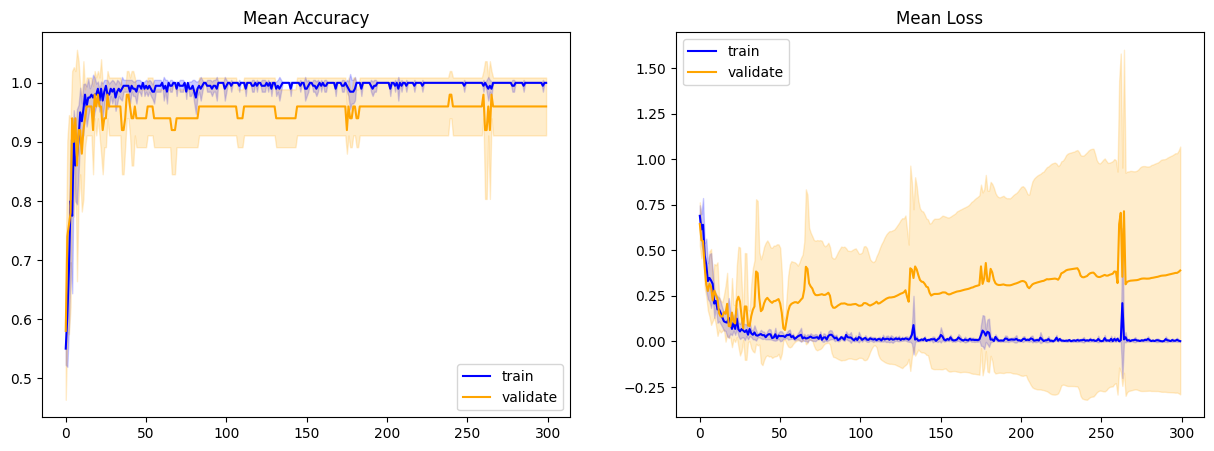

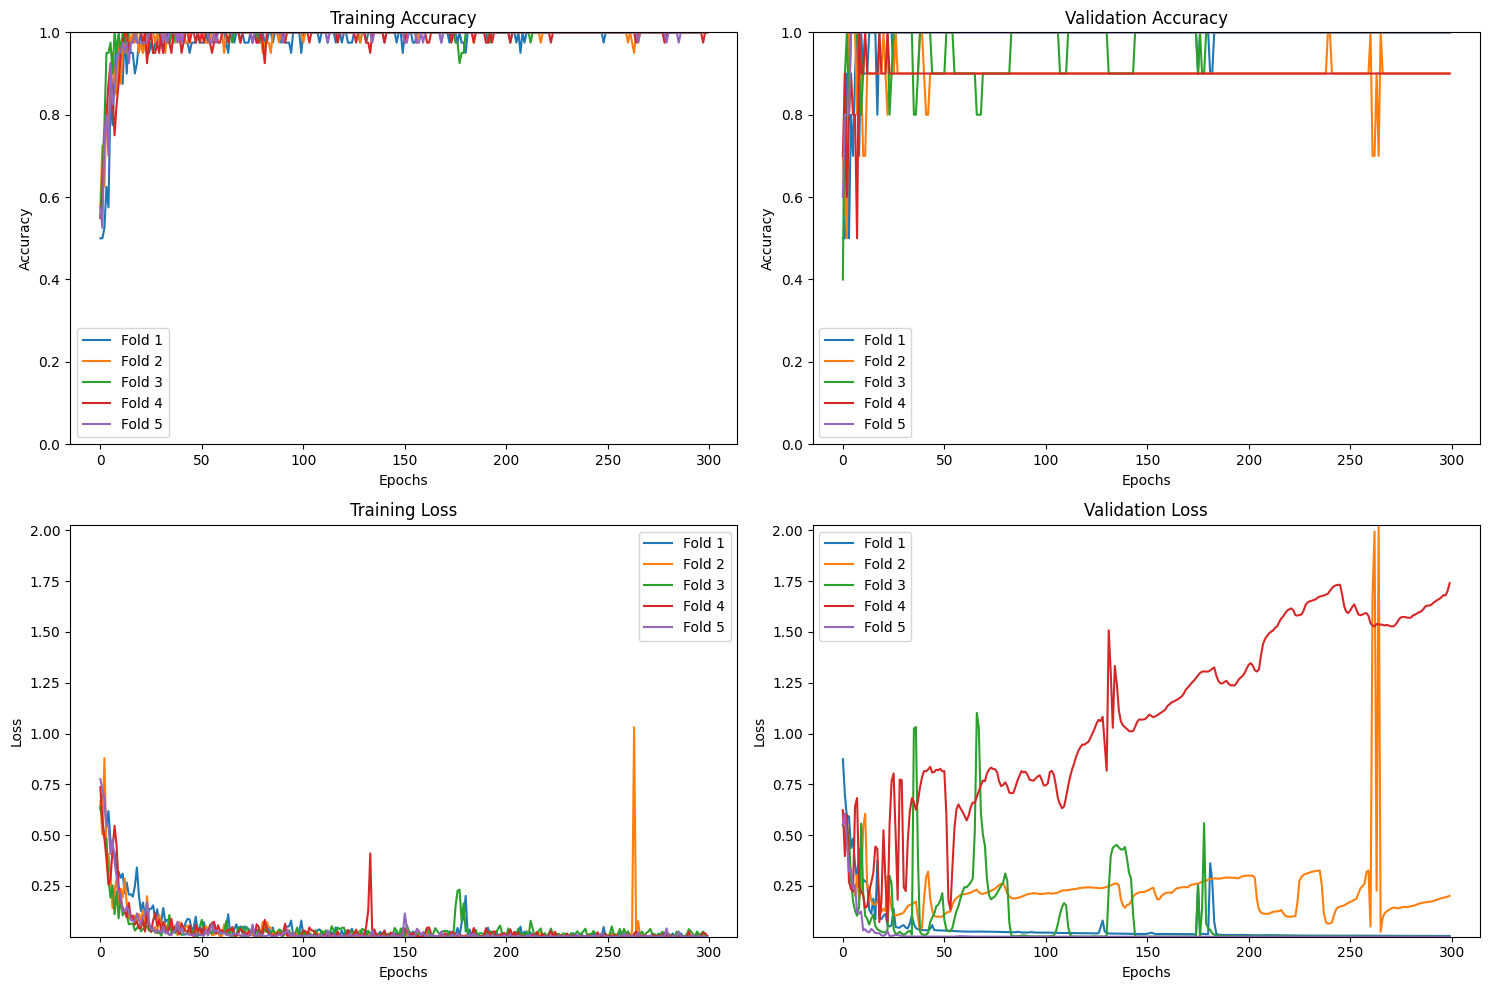

In [25]:
crossvalidate(df, model0, predictors, 'timepoint', kf)

As we can see for KO dataset it worked perfectly as well, the model is much bigger and thus the loss functions are fluctuating much more but we have very nice accuracy. It is worth mentioning that we have only one sample per pond per timepoint so there is no replication of samples. and that means that the differences between timepoints seems to be significant. Now we will try to check if CNN's give similar results.

In [26]:
model0c = keras.Sequential()

model0c.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model0c.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model0c.add(Flatten())

model0c.add(keras.layers.Dense(1024, activation ='relu'))
model0c.add(keras.layers.Dense(254, activation ='relu'))
model0c.add(keras.layers.Dropout(rate=0.25))

model0c.add(keras.layers.Dense(128, activation ='relu'))

model0c.add(keras.layers.Dense(64, activation ='relu'))
model0c.add(keras.layers.Dense(16, activation ='relu'))
model0c.add(keras.layers.Dropout(rate=0.25))
model0c.add(keras.layers.Dense(16, activation ='relu'))

model0c.add(keras.layers.Dense(2, activation ='softmax'))

print(model0c.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model0c.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6364, 3)        │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6362, 2)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12724)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │    13,030,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,333,030 (50.86 MB)

 Trainable params: 13,333,030 (50.86 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 2
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 1.0000 - loss: 2.8690e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
predicted classes:       [0 0 1 1 0 1 1 0 1 0]
true validation classes: [0 0 1 1 0 1 1 0 1 0]
mean confidence score: 4489703766422.736, sd confidence score: 10570388582430.484
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0059
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
predicted classes:       [1 0 1 1 1 1 0 0 1 0]
true validation classes: [1 0 1 1 1 1 0 0 1 0]
mean confidence score: 18854780861835.582, sd confidence score: 56564336121382.555
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0016
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predicted classes:       [1 0 0 1 1 0 1 0 1 1]
true validation classes: [1 0 0 1 1 0 1 0 1 1]
mean confidence score: 3.536296145057128e+16, sd confidence score: 1.0572802610966518e+17
training for 4 subset
1/1 ━━━━━━━━━━━━━━

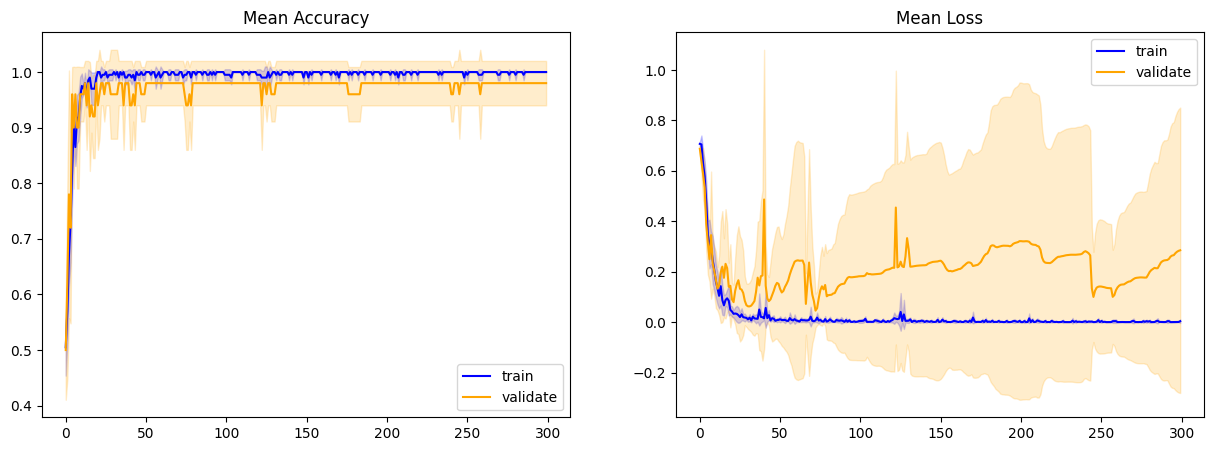

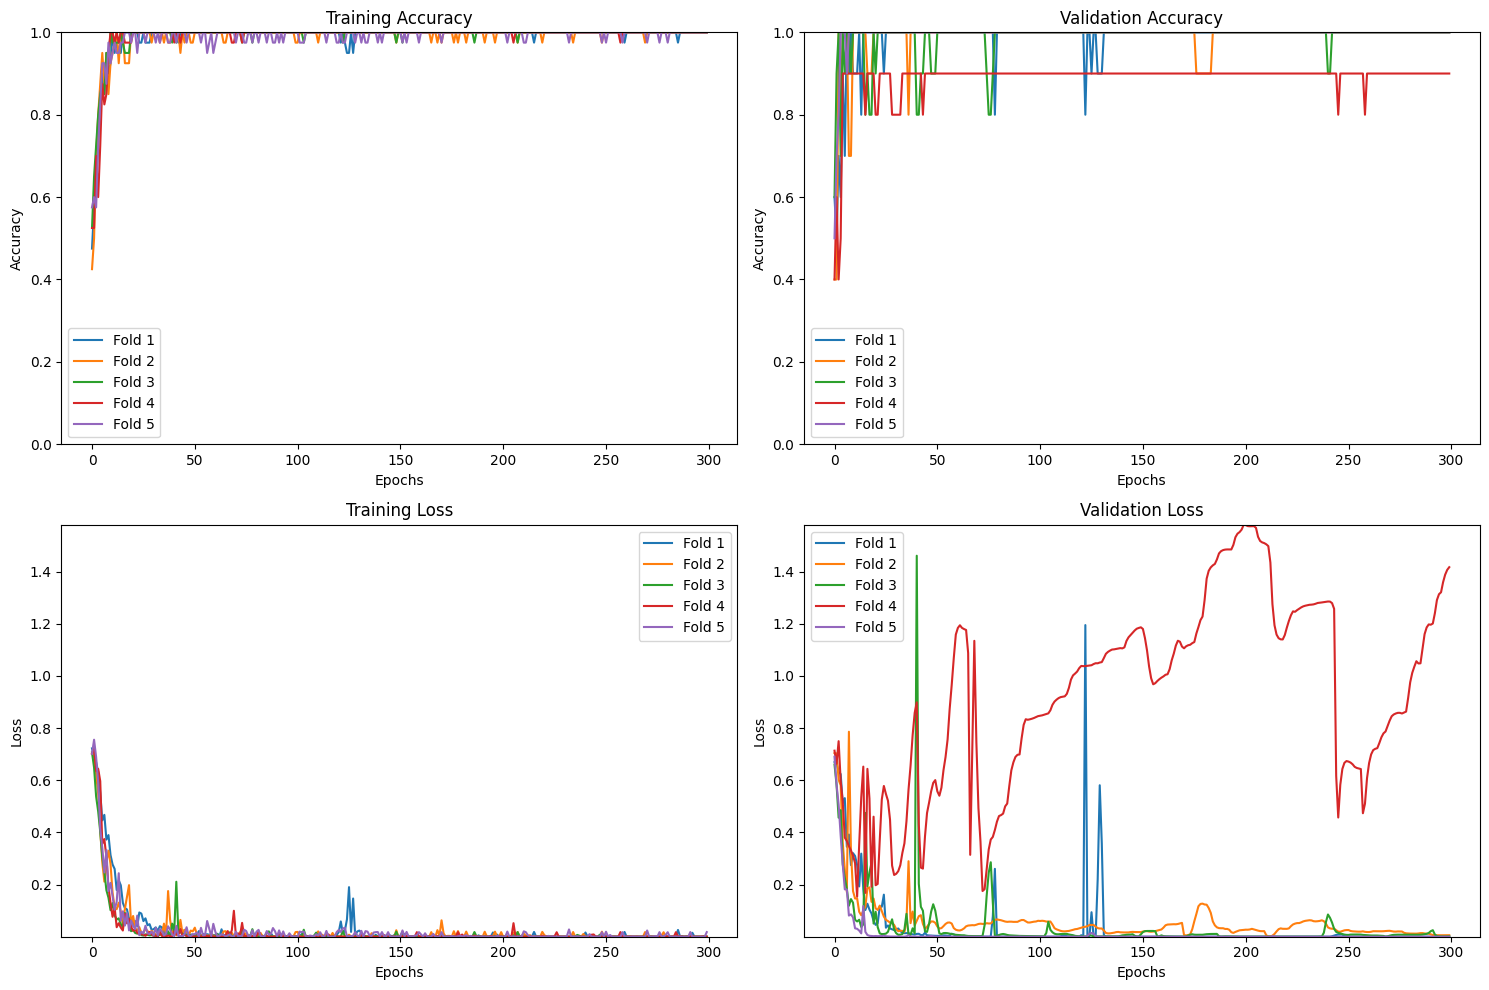

In [27]:
crossvalidate(df, model0c, predictors, 'timepoint', kf)

Convolutional approach proved to yield same results as non convolutional having very good accuracy for all the folds.

### Convolution only ponds

In [ ]:
model2_2 = keras.Sequential()

model2.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model2.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model2.add(Flatten())

model2.add(keras.layers.Dense(1024, activation ='relu'))
model2.add(keras.layers.Dense(254, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))

model2.add(keras.layers.Dense(128, activation ='relu'))

model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dense(16, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

print(model2.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 6364, 3)        │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6362, 2)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12724)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1024)           │    13,030,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,333,081 (50.86 MB)

 Trainable params: 13,333,081 (50.86 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3000 - loss: 6.7183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
predicted classes:       [4 1 3 4 4 0 3 4 3 3]
true validation classes: [0 1 1 2 3 3 3 3 3 4]
mean confidence score: 15353.2373, sd confidence score: 35182.272
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1000 - loss: 1.9544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
predicted classes:       [3 3 4 3 0 3 1 0 3 4]
true validation classes: [0 0 0 1 1 2 3 3 4 4]
mean confidence score: 15.2399, sd confidence score: 29.3553
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1000 - loss: 4.9364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
predicted classes:       [1 4 1 1 0 1 4 2 1 1]
true validation classes: [0 0 0 1 2 2 2 3 3 4]
mean confidence score: 298.9407, sd confidence score: 494.4178
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3000 - loss: 3.2140
1/1 ━━━━━━━━━━━━

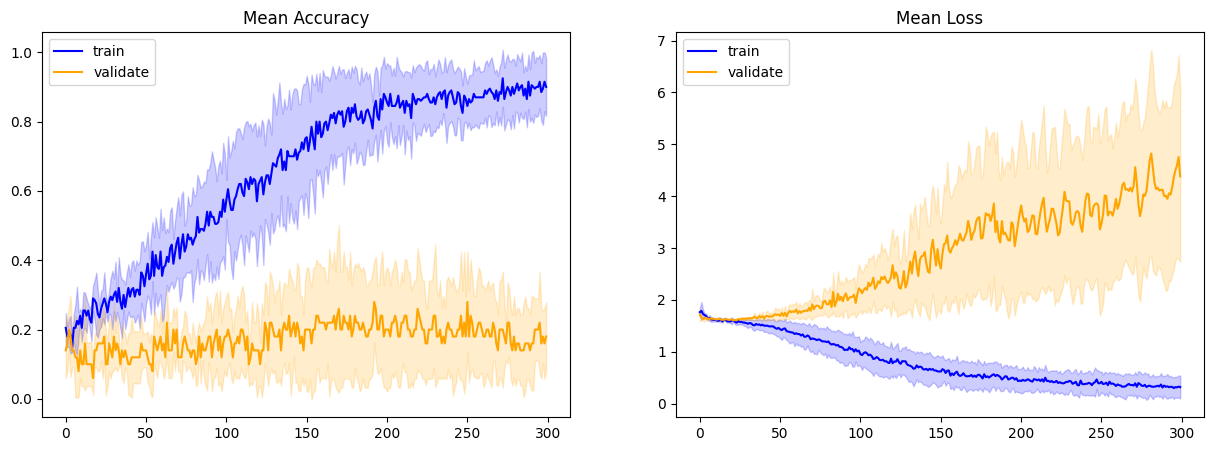

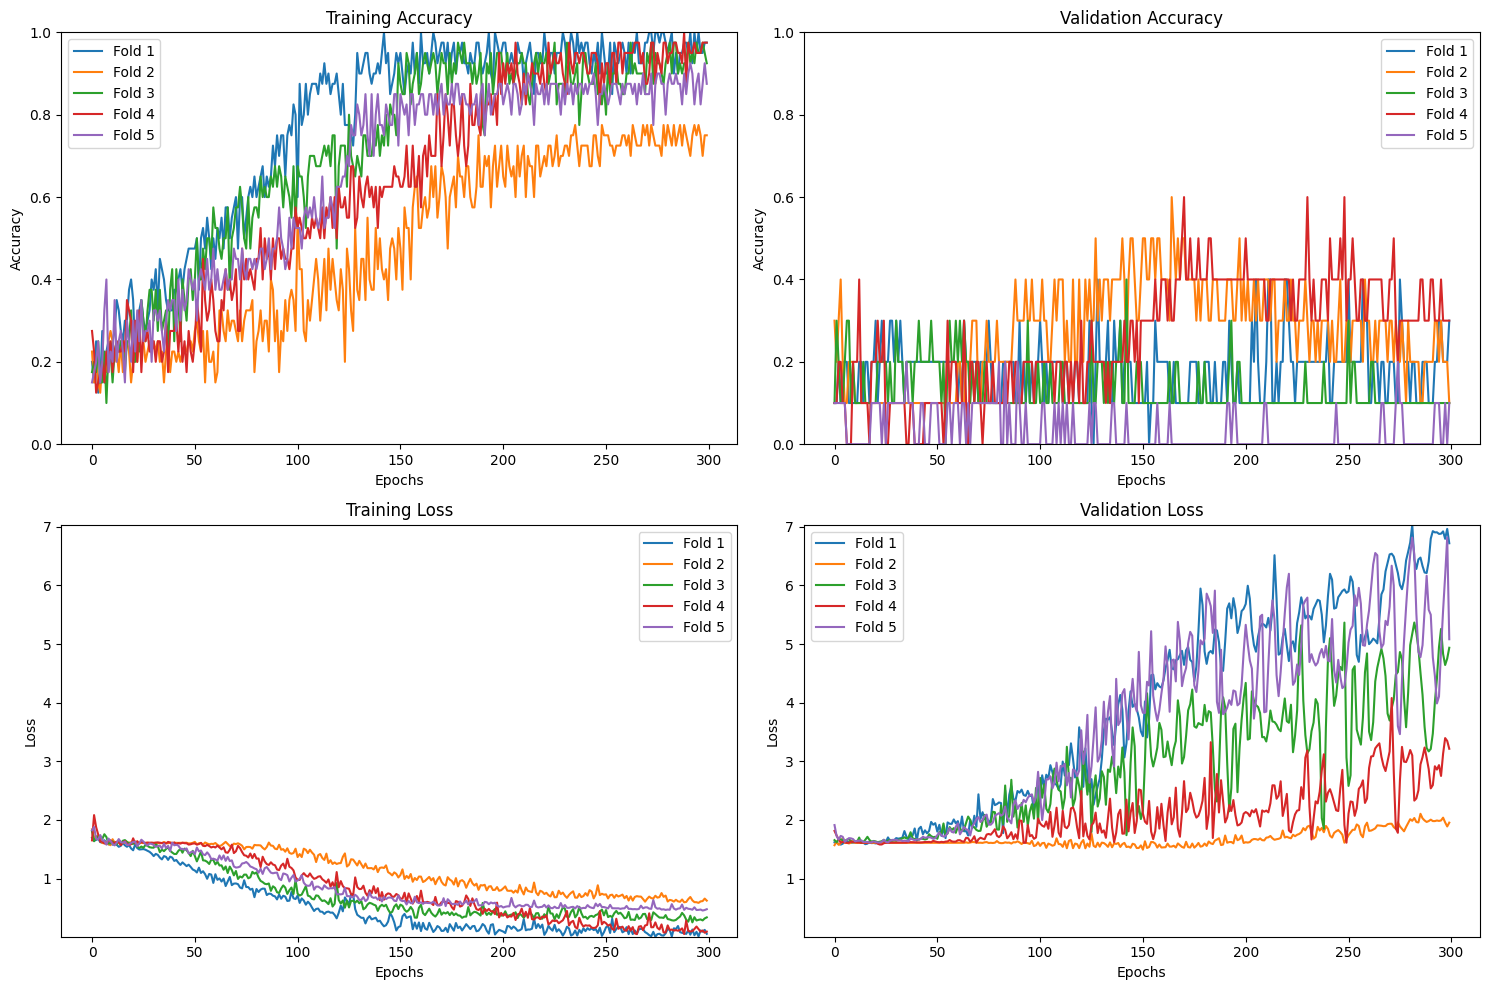

In [29]:
crossvalidate(df, model2, predictors, 'pond', kf, True)

As we've seen for bacteria datasets modeling differences between ponds didnt result in any good classification.

### Modeling ponds in 1 timepoint

In [20]:
df_1_tp = df[df['timepoint'] == 0]

In [21]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='sigmoid'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='sigmoid'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │     1,630,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,648,037 (6.29 MB)

 Trainable params: 1,648,037 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0000e+00 - loss: 2.2315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted classes:       [4 3 1 1 4]
true validation classes: [0 0 2 2 3]
mean confidence score: 2.4773, sd confidence score: 1.0799
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2000 - loss: 1.7823
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [2 1 0 2 1]
true validation classes: [1 1 2 3 3]
mean confidence score: 2.5053, sd confidence score: 2.9431
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2000 - loss: 1.7689
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [4 1 1 3 3]
true validation classes: [0 0 2 3 4]
mean confidence score: 1.8142, sd confidence score: 0.9597
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 2.1993
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [4 2 3 2 0]
true v

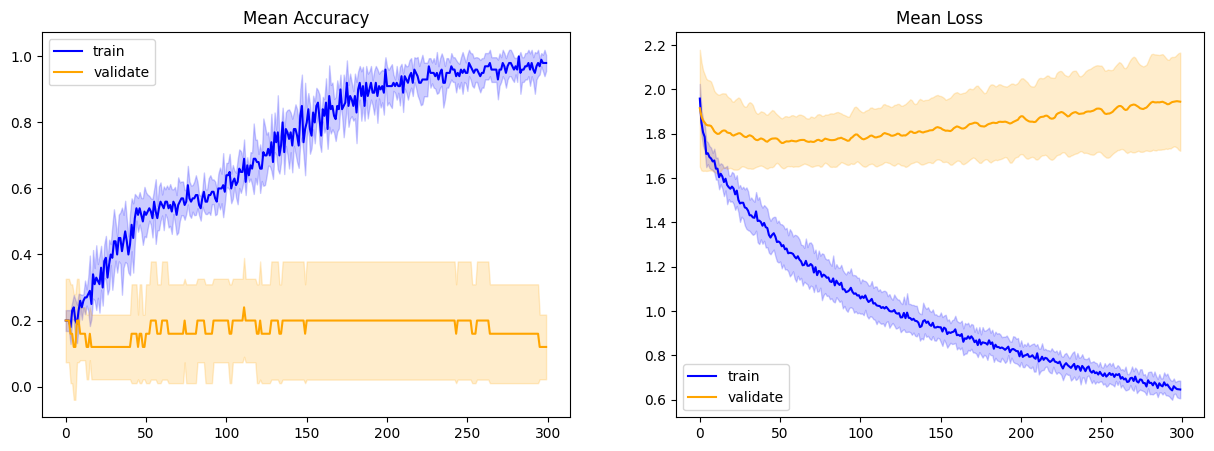

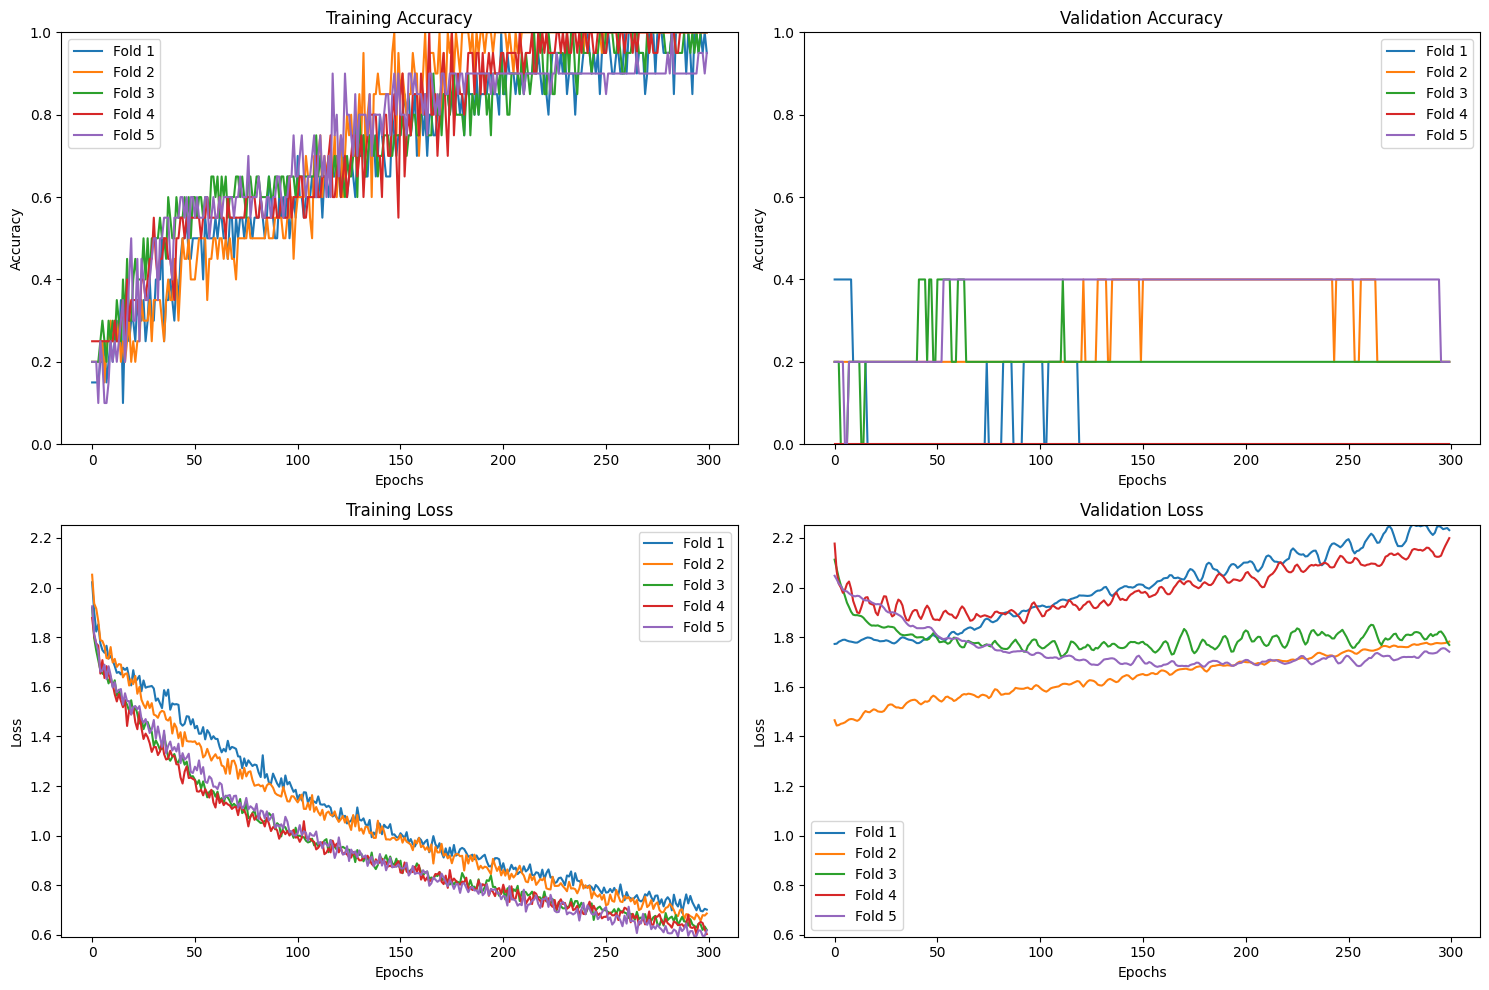

In [22]:
crossvalidate(df_1_tp, model2, predictors, 'pond', kf)

XXXXX

### Modeling ponds in second timepoint

In [23]:
df_2_tp = df[df['timepoint'] == 1]

In [25]:
reset_weights(model2)
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='sigmoid'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='sigmoid'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │     1,630,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,648,037 (6.29 MB)

 Trainable params: 1,648,037 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2000 - loss: 1.7135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted classes:       [1 2 1 3 3]
true validation classes: [0 0 2 2 3]
mean confidence score: 1.1674, sd confidence score: 0.2333
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4000 - loss: 1.9144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted classes:       [0 1 4 3 0]
true validation classes: [1 1 2 3 3]
mean confidence score: 2.7775, sd confidence score: 1.9113
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4000 - loss: 1.7164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [1 4 4 3 4]
true validation classes: [0 0 2 3 4]
mean confidence score: 2.3439, sd confidence score: 1.068
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2000 - loss: 1.5289
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [0 0 3 2 3]
true validation

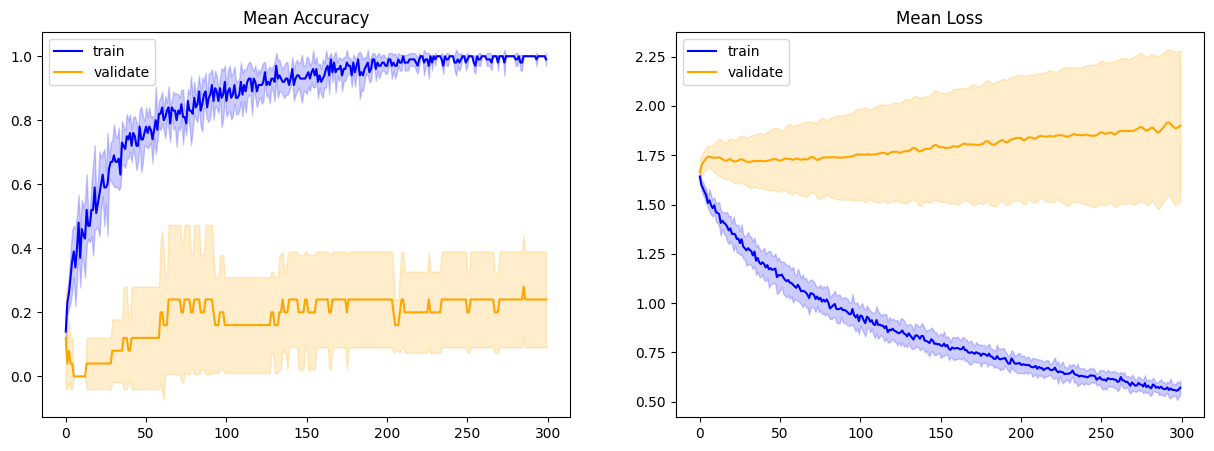

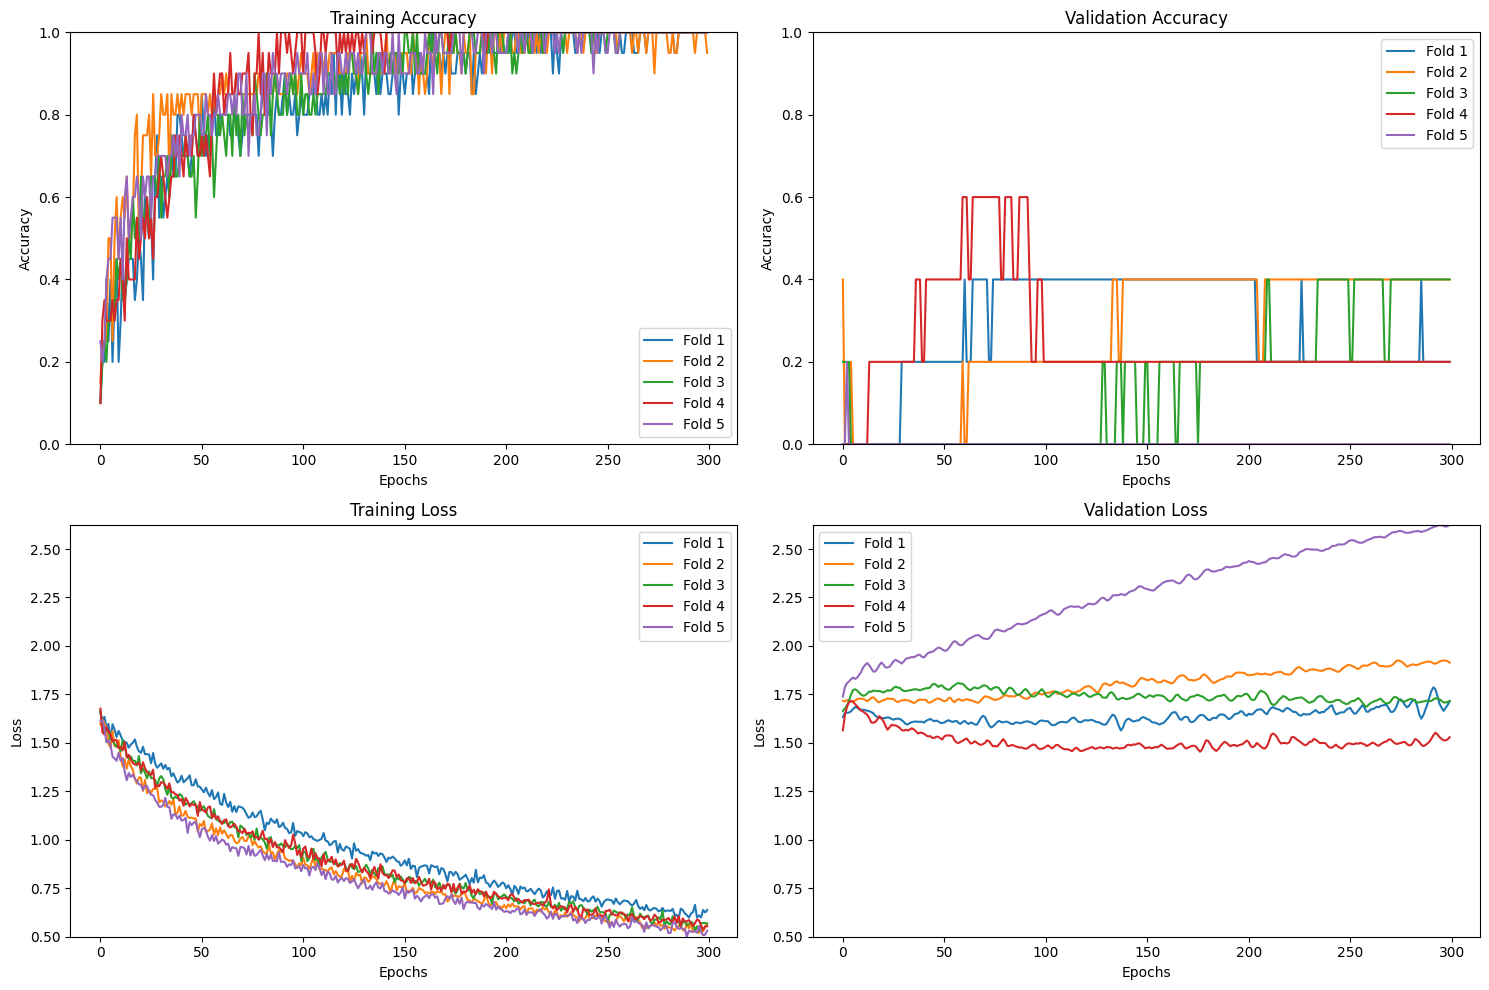

In [26]:
crossvalidate(df_2_tp, model2, predictors, 'pond', kf)

For both of the timepoints we were not able to classify with any satisfactionary results for any fold, this is the same case as for bacteria dataset.

### Oversampling all of the classes in 5 class classification for both timepoints


In [31]:
train_val_df.shape, test_df.shape

((40, 6373), (10, 6373))

In [33]:
empty_class = pd.DataFrame(0, index=range(40),columns=train_val_df.columns)
#empty_class[] = np.random.rand(40, empty_class.shape[1])
empty_class['pond'] = 9


In [34]:
train_val_df_empty_class = pd.concat([train_val_df, empty_class], axis=0)

In [35]:
smote = SMOTE(random_state=111)
X = train_val_df_empty_class[predictors].values
y = train_val_df_empty_class['pond']

In [36]:
X.shape, y.shape

((80, 6368), (80,))

In [37]:
X_smote, y_smote = smote.fit_resample(X, y)
y_smote.shape

(240,)

In [38]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)
df_smote_cleared = df_smote[df_smote['pond'] != 9]
df_smote_cleared.reset_index(drop=True, inplace=True)
print(df_smote_cleared.shape)
df_smote_cleared['pond'].value_counts()

(200, 6369)


pond
2    40
1    40
4    40
3    40
0    40
Name: count, dtype: int64

(80, 6368) (80,)
(240, 6368) (240,)
Number of classes: 5
training for 1 subset


C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0342  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicted classes:       [2 4 4 0 1 0 0 1 3 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4
 4 4 4]
true validation classes: [2 4 4 0 1 0 0 1 3 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4
 4 4 4]
mean confidence score: 168.464, sd confidence score: 52.9115
training for 2 subset
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0162 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
predicted classes:       [4 3 3 2 0 1 0 1 4 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4
 4 4 4]
true validation classes: [4 3 3 2 0 1 0 1 4 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4
 4 4 4]
mean confidence score: 246.1372, sd confidence score: 41.6306
training for 3 subset
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0166 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
predicted classes:       [3 4 3 1 2 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 

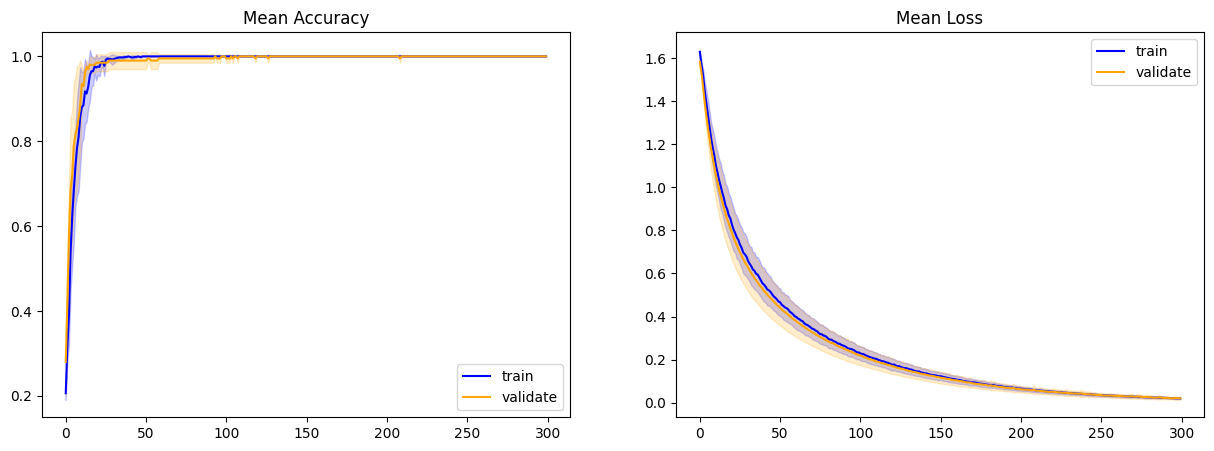

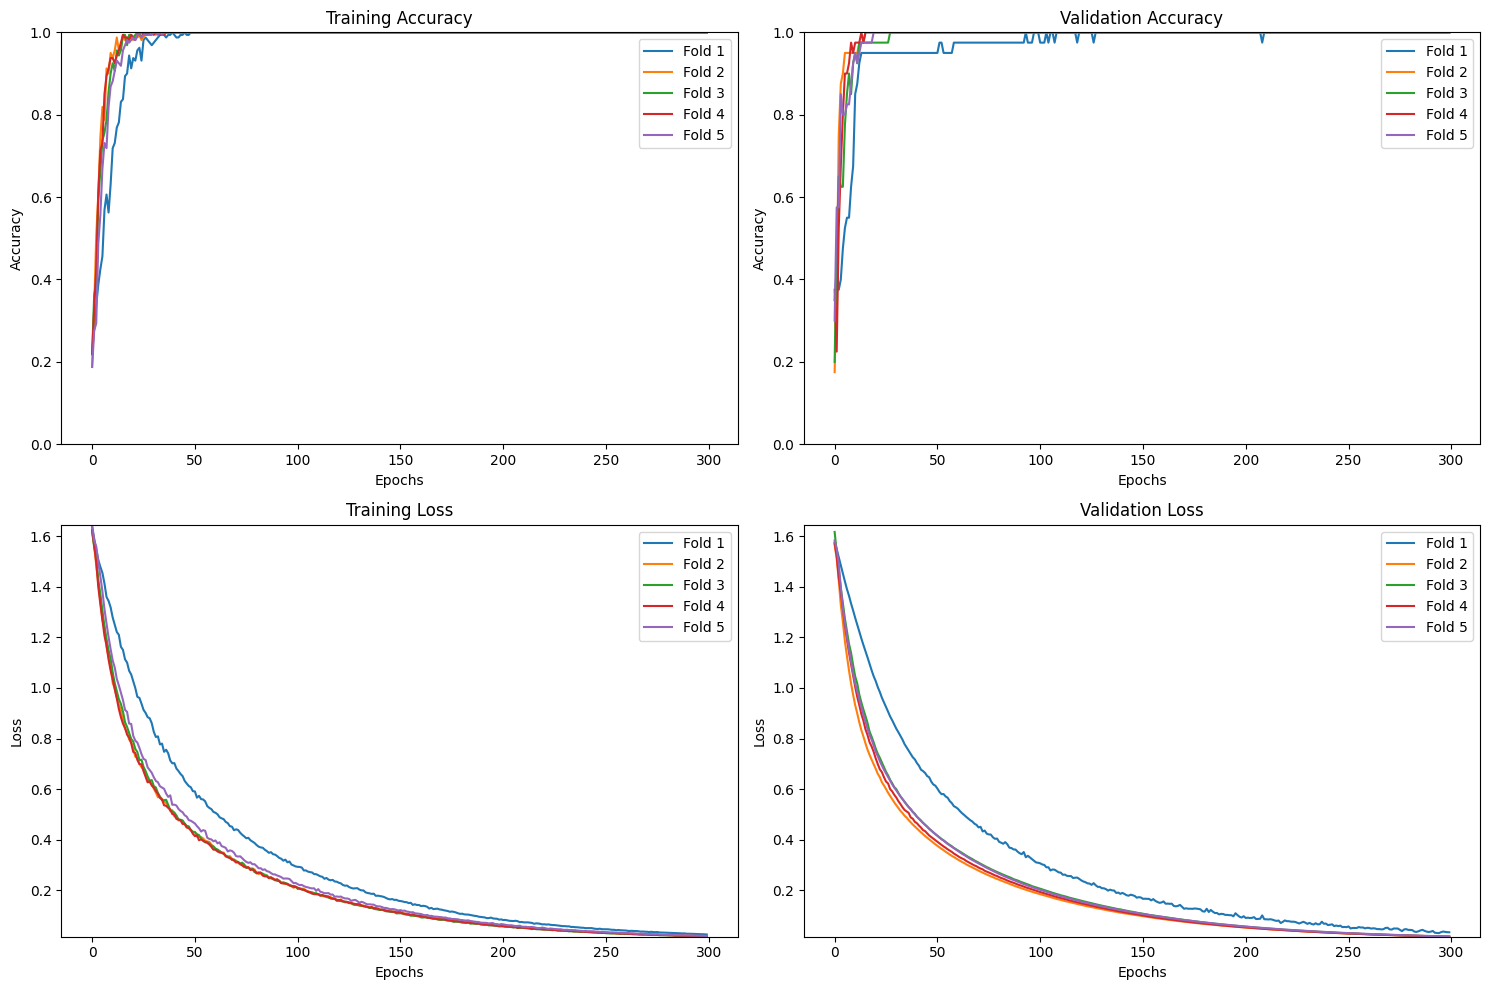

In [39]:
print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

model3 = keras.Sequential()
model3.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='sigmoid'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='sigmoid'))
model3.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)
crossvalidate(df_smote_cleared, model3, predictors, 'pond', kf)

In [40]:
X = df_smote_cleared[predictors].values
y = keras.utils.to_categorical(df_smote_cleared['pond'].values)
y_test = keras.utils.to_categorical(test_df['pond'].values)
X_test = test_df[predictors].values
reset_weights(model3)   

history5 = model3.fit(X, y, epochs=300, batch_size=5,validation_data=(X_test, y_test), verbose=1, callbacks=[es_callback])

Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2028 - loss: 1.6734 - val_accuracy: 0.4000 - val_loss: 1.5566
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2235 - loss: 1.5843 - val_accuracy: 0.2000 - val_loss: 1.5595
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3758 - loss: 1.5210 - val_accuracy: 0.2000 - val_loss: 1.5380
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5215 - loss: 1.4475 - val_accuracy: 0.2000 - val_loss: 1.5625
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6335 - loss: 1.3655 - val_accuracy: 0.2000 - val_loss: 1.5733
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7064 - loss: 1.2784 - val_accuracy: 0.3000 - val_loss: 1.5892
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8128 - loss: 1.2079 - val_accuracy: 0.4000 - val_loss: 1.6037
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8449 - loss: 1.1636 - val_accuracy: 0.4000 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2000 - loss: 1.5380
[1.537971019744873, 0.20000000298023224]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted values: [3 3 3 3 3 0 0 3 3 3]
True values: [3 1 4 0 3 2 2 1 0 4]


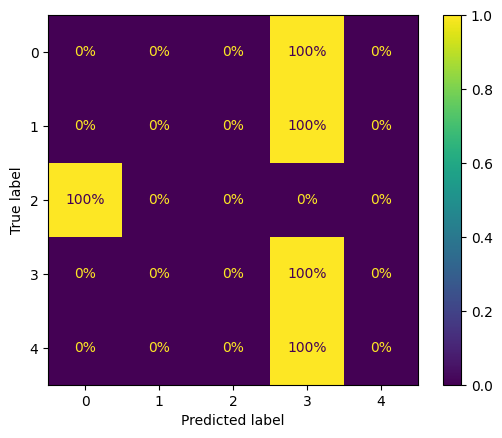

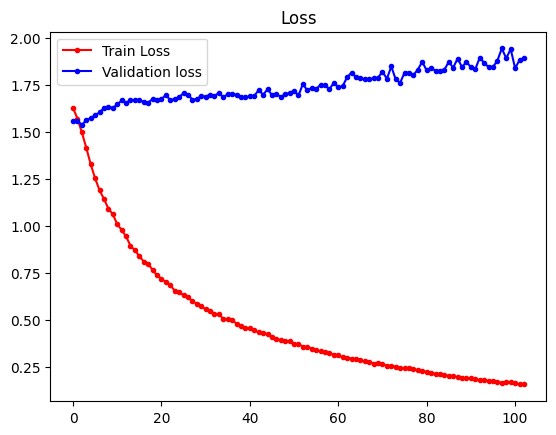

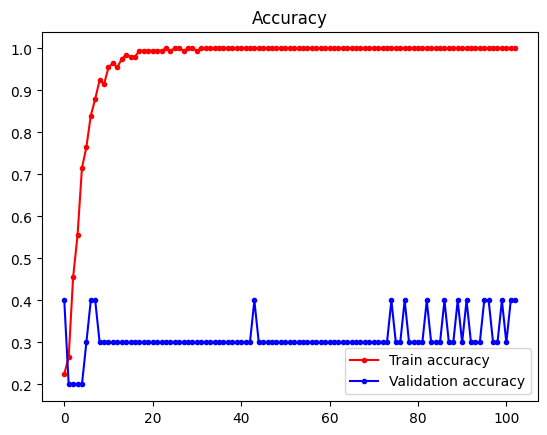

In [41]:
evaluate_model(model3, history5, X_test, y_test)

We can observe similar results as before, great validationa accuracy bu lackluster test accuracy due to same reasons.

## XGBoost analysis

For comparison we will replicate our analysis use XGBoost which is based on Gradient Boosting and utilising Decision trees, we could use Random forests but this prooved to be a better approach for smaller dataset and we dont require faster and better computing performance that are offered by random forests.

In [42]:
import xgboost as xgb

In [43]:

train_val_df.shape, test_df.shape

((40, 6373), (10, 6373))

In [47]:
X_train = train_val_df[predictors].values
X_test = test_df[predictors].values


### Modeling timepoints only

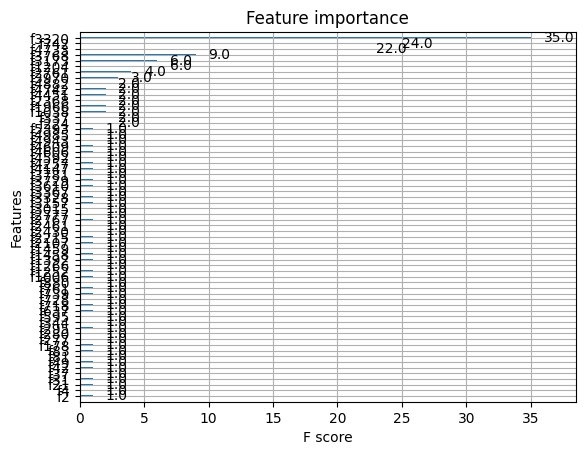

In [50]:
dtrain = xgb.DMatrix(X_train, label=train_val_df['timepoint'])
dtest = xgb.DMatrix(X_test, label=test_df['timepoint'])
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}
bst2 = xgb.train(params, dtrain, 1000, num_boost_round=100)

xgb.plot_importance(bst2)
xgb_pred = bst2.predict(dtest)
xgb_acc = accuracy_score(test_df['timepoint'], xgb_pred)


[0 0 1 0 1 1 0 1 1 0]
[0. 0. 1. 0. 1. 1. 0. 1. 1. 0.]
1.0


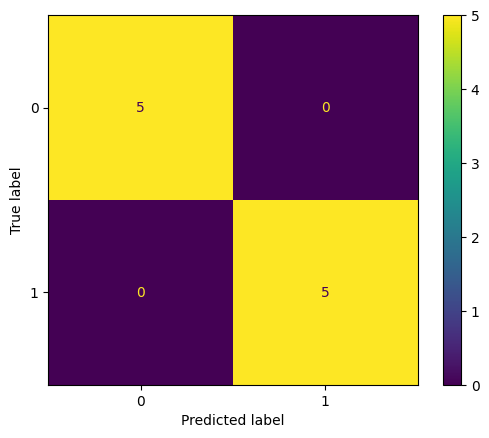

In [53]:
print(test_df['timepoint'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(test_df['timepoint'].values, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()

When comparing our Nerual network approach to some more robust machine learning approach as XGBoost we can see that for first analysis whchich is modeling only timepoints we have 100% accuracy, very similar to NN's

### Classifying only ponds for both timepoints

In [48]:
dtrain = xgb.DMatrix(X_train, label=train_val_df['pond'].values)  
dtest = xgb.DMatrix(X_test, label=test_df['pond'].values)
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}

bst2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst2.predict(dtest)
xgb_acc = accuracy_score(test_df['pond'].values, xgb_pred)

[3 1 4 0 3 2 2 1 0 4]
[4. 1. 2. 2. 3. 2. 2. 1. 3. 3.]
0.5


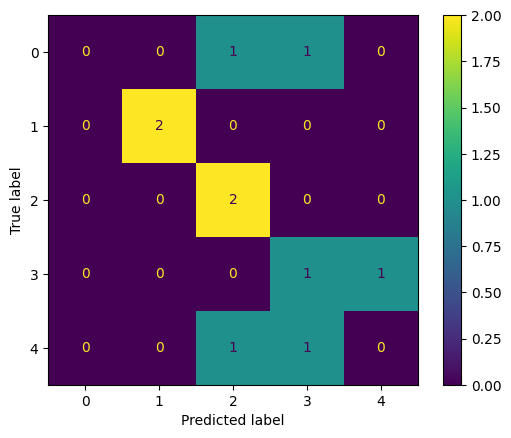

In [49]:
print(test_df['pond'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(test_df['pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

For our ponds in both timepoints at the same time we can see that the results are only slightly better - achiveing 0.5 acc in comparison to 0.3 for NN's

#### Modeling only first timepoint

In [ ]:
df_first_tp = df[df['timepoint'] == 0]
print(df_first_tp.shape)
df1tp_train, df1tp_test = train_test_split(df_first_tp, test_size=5, random_state=111, stratify=df_first_tp['pond'])
X_2_train = df1tp_train[predictors].values
X_2_test = df1tp_test[predictors].values

(25, 6373)


In [59]:
dtrain = xgb.DMatrix(X_2_train, label=df1tp_train['pond'].values)
dtest = xgb.DMatrix(X_2_test, label=df1tp_test['pond'].values)
bst3_1 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst3_1.predict(dtest)
xgb_acc = accuracy_score(df1tp_test['pond'].values, xgb_pred)

[2 4 1 0 3]
[2. 3. 1. 2. 3.]
0.6


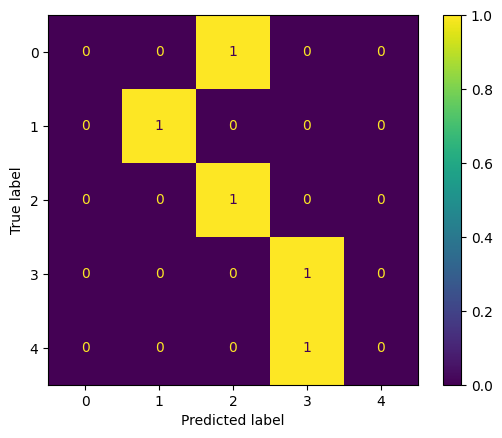

In [61]:
print(df1tp_test['pond'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(df1tp_test['pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

### Modeling only second timepoint

In [54]:
df_second_tp = df[df['timepoint'] == 1]
df_second_tp.shape

df_2tp_train, df_2tp_test = train_test_split(df_second_tp, test_size=5, random_state=111, stratify=df_second_tp['pond'])
print(df_2tp_train.shape, df_2tp_test.shape)
X_2_train = df_2tp_train[predictors].values
y_2_train = df_2tp_train['pond'].values
X_2_test = df_2tp_test[predictors].values
y_2_test = df_2tp_test['pond'].values



(20, 6373) (5, 6373)


In [55]:
dtrain = xgb.DMatrix(X_2_train, label=y_2_train)  
dtest = xgb.DMatrix(X_2_test, label=y_2_test)
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}

bst3 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst3.predict(dtest)
xgb_acc = accuracy_score(y_2_test, xgb_pred)

[2 4 1 0 3]
[3. 1. 4. 1. 2.]
0.0


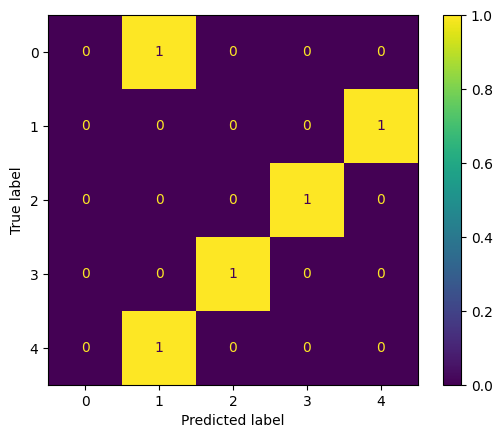

In [56]:
print(y_2_test)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(y_2_test, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

For 1 timepoint where there should be more differenes from biological perspecite as it is only one week after adding supplements and micriobiome didnt have time to get back to its origianl structure we can see that xgboost algorythm managed to reach 0.6 accuracy (for 5 test samples it correctly classified 3). However for second timepoint probably because of how much time has passed we observed accuracy of 0.

### Conclusions from XGBoost
The results from the XGBoost model are slightly better especially for modeeling ponds in 1 timepoint to those obtained with neural networks, For The modelinga imed at classyifing ponds the results were bad only slightly better than for NN's this somewhat prooves that there might be not significant enough differences between ponds for the algorythm to detect.